In [ ]:
# this file find weights for 5x5, 7x7, 9x9 patterns
# chemical naming: AHL is the same as OC6, CHL is the same as OHC14

In [1]:
from numpy.random import RandomState
import numpy as np
np.set_printoptions(precision=2,suppress=True)

import matplotlib.pyplot as plt
import scipy.optimize as opt
from math import *

from scipy.optimize import basinhopping,minimize,differential_evolution
from scipy.stats import moment

In [2]:
# basis functions, phi_pos, phi_neg
def transf_pos(x,K=2.0,y0=0.001,ym=1.5,n=2):
    result=ym*((x/K)**n)/(1+(x/K)**n)+ym*y0
    return result

def transf_neg(x,K=2.0,y0=0.001,ym=1.5,n=2):
    result=ym/(1+(x/K)**n)+y0*ym
    return result

In [3]:
def noisy(vector):
    result=[]
    for i in range(0,len(vector)):
        v=vector.copy()
        v[i]=np.logical_not(vector[i]).astype(int)
        #print(i,vector[i],v[i])
        result.append(v)
    return result

In [4]:
zv_5x5=[1,1,1,0,0,\
        0,0,1,0,0,\
        0,0,1,0,0,\
        0,0,1,0,0,\
        0,0,1,1,1]

zv_7x7=[1,1,1,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,0,0,0,\
        0,0,0,1,1,1,1]

zv_9x9=[1,1,1,1,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,0,0,0,0,\
        0,0,0,0,1,1,1,1,1]    

In [5]:
vv_5x5=[1,0,0,0,1,\
        1,0,0,0,1,\
        1,0,0,0,1,\
        0,1,0,1,0,\
        0,0,1,0,0]

vv_7x7=[1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        0,1,0,0,0,1,0,\
        0,0,1,0,1,0,0,\
        0,0,0,1,0,0,0]

vv_9x9=[1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        0,1,0,0,0,0,0,1,0,\
        0,0,1,0,0,0,1,0,0,\
        0,0,0,1,0,1,0,0,0,\
        0,0,0,0,1,0,0,0,0]    

In [6]:
nv_5x5=[0,0,0,0,0,\
        0,1,1,1,0,\
        1,0,0,0,1,\
        1,0,0,0,1,\
        1,0,0,0,1]

nv_7x7=[0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,\
        0,1,1,1,1,1,0,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1,\
        1,0,0,0,0,0,1]

nv_9x9=[0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,\
        0,0,1,1,1,1,1,0,0,\
        0,1,0,0,0,0,0,1,0,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1,\
        1,0,0,0,0,0,0,0,1]

In [7]:
# 5x5 pattern set
zpatterns=([zv_5x5]+noisy(zv_5x5))
vpatterns=([vv_5x5]+noisy(vv_5x5))
npatterns=([nv_5x5]+noisy(nv_5x5))

patterns_5x5=zpatterns+vpatterns+npatterns

In [8]:
# 7x7
zpatterns=([zv_7x7]+noisy(zv_7x7))
vpatterns=([vv_7x7]+noisy(vv_7x7))
npatterns=([nv_7x7]+noisy(nv_7x7))

patterns_7x7=zpatterns+vpatterns+npatterns

In [9]:
# 9x9
zpatterns=([zv_9x9]+noisy(zv_9x9))
vpatterns=([vv_9x9]+noisy(vv_9x9))
npatterns=([nv_9x9]+noisy(nv_9x9))

patterns_9x9=zpatterns+vpatterns+npatterns

In [16]:
# define variables
# for 5x5 patters, size=25, patterns=patterns_5x5
# for 7x7 patters, size=49, patterns=patterns_7x7
# for 9x9 patters, size=81, patterns=patterns_9x9

size=25
patterns=patterns_5x5

target_L=0.0
target_H=1.2
lenth=int(len(patterns)/3)

target_0=np.array([target_H]*lenth+[target_L]*lenth+[target_L]*lenth)
target_1=np.array([target_L]*lenth+[target_H]*lenth+[target_L]*lenth)
target_2=np.array([target_L]*lenth+[target_L]*lenth+[target_H]*lenth)

target=target_0
#----
AHL_unit_level=30
transf_p=np.zeros(2)
transf_n=np.zeros(2)

transf_p[0]=transf_pos(x=0,K=50,y0=0.1,ym=1.0,n=0.45)
transf_p[1]=transf_pos(x=AHL_unit_level,K=50,y0=0.1,ym=1.0,n=0.45)
transf_n[0]=transf_neg(x=0,K=0.252,y0=0.341,ym=735,n=0.67)
transf_n[1]=transf_neg(x=AHL_unit_level,K=0.252,y0=0.341,ym=735,n=0.67)

phi_pos=np.array([transf_p]*size)
phi_neg=np.array([transf_n]*size)

In [17]:
def examine_output(w,P,phi_pos,phi_neg):
    y_n=np.zeros(len(P))
    w_ph_=np.zeros(len(P))

    for n in range(0,len(P)):
        pttn=np.array(P[n])
        
        phi_nw=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)+\
            (1.0-w/np.sqrt(w**2))/2*output_fcn(pttn,phi_neg)/w
                
        w_ph_[n]=np.dot(w,phi_nw)/len(w)
        y_n[n]=activate(w_ph_[n])
        
    return y_n,w_ph_

def output_fcn(pttn,fcn):
    
    CHL_levels=np.zeros(len(pttn))
    for i in range(0,len(pttn)):
        CHL_levels[i]=fcn[i][pttn[i]]
        
    return CHL_levels

def activate(x):
    K,y0,ym_x,n= 1.10292919e+03,1.94584842e-02,2.15950963e+04,2.33038211e+00

    result=transf_pos(x.sum(),K=K,y0=y0/1e4,ym=2.0,n=n).sum()
    return result

In [18]:
def train_step1(target,size,eta,phi_pos,phi_neg):
    rndstate=RandomState(2)
    w=rndstate.random_sample(size)
    r=size

    w_series=[]
    y_series=[]
    delta_series=[]

    for it in range(0,350):
        y_n=np.zeros(len(patterns))
        g_n=np.zeros(len(patterns))
        delta_err=np.zeros(size)
        phi_n=[]
    
        for n in range(0,len(patterns)):
            pttn=np.array(patterns[n])
            # consider pttn as indexes in vector x, 0 means x[0], 1 means x[1]
        
            phi_nw=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)+\
                (1.0-w/np.sqrt(w**2))/2*output_fcn(pttn,phi_neg)/w

            g_n[n]=np.dot(w,phi_nw)/r
            y_n[n]=activate(g_n[n])            
            
            tmp=(y_n[n]-target[n])
            tmp=min(target_H,tmp)

            phi_nw_pos=(1.0+w/np.sqrt(w**2))/2*output_fcn(pttn,phi_pos)                
            delta_err+=tmp*phi_nw_pos
        
        w=w-eta*delta_err 
        y_series.append(y_n)
        w_series.append(w)
        delta_series.append(delta_err)
    
    return w,y_series,w_series,delta_series

In [19]:
# demo example, 5x5 patterns
# using AHL_unit_level=30, can obtain the same output values as in Table S4 
# also in 3x3 patters, we set AHL_unit_level=33; using AHL_unit_level=30, the output is somewhat different

w0_5x5,yseries0_5x5,_,_=train_step1(target_0,size=5**2,eta=1.8,phi_pos=phi_pos,phi_neg=phi_neg)
w1_5x5,yseries1_5x5,_,_=train_step1(target_1,size=5**2,eta=1.8,phi_pos=phi_pos,phi_neg=phi_neg)
w2_5x5,yseries2_5x5,_,_=train_step1(target_2,size=5**2,eta=1.8,phi_pos=phi_pos,phi_neg=phi_neg)

In [24]:
print('5x5, w0: ',np.round(w0_5x5))
print('5x5, w1: ',np.round(w1_5x5))
print('5x5, w2: ',np.round(w2_5x5))

5x5, w0:  [4462. 5273. 5273.  815.    1.    1.    1. 4463.    1.    1.   -5.  815.
 5273.  815.   -5.    2.    2. 5273.    2.    1.    1.  814. 4462. 5273.
 4462.]
5x5, w1:  [4462.    1.    1.  815. 5273. 5273.    1.   -5.    1. 5273. 4463.  815.
    1.  815. 4462.    2. 5273.    1. 5273.    1.    1.  814. 4462.    1.
   -5.]
5x5, w2:  [  -5.    1.    1.  815.    1.    1. 5273. 4463. 5273.    1. 4463.  815.
    1.  815. 4462. 5273.    2.    1.    2. 5273. 5273.  814.   -5.    1.
 4462.]


In [43]:
# demo example, 7x7 patterns
# need to jump to previous code to reset size=49, patterns=patterns_7x7

output_0_7x7,_=examine_output(w0_7x7,patterns_7x7,phi_pos,phi_neg)
output_1_7x7,_=examine_output(w1_7x7,patterns_7x7,phi_pos,phi_neg)
output_2_7x7,_=examine_output(w2_7x7,patterns_7x7,phi_pos,phi_neg)


In [ ]:
# demo example, 9x9 patterns
# need to jump to previous code to reset size=81, patterns=patterns_9x9

output_0_9x9,_=examine_output(w0_9x9,patterns_9x9,phi_pos,phi_neg)
output_1_9x9,_=examine_output(w1_9x9,patterns_9x9,phi_pos,phi_neg)
output_2_9x9,_=examine_output(w2_9x9,patterns_9x9,phi_pos,phi_neg)

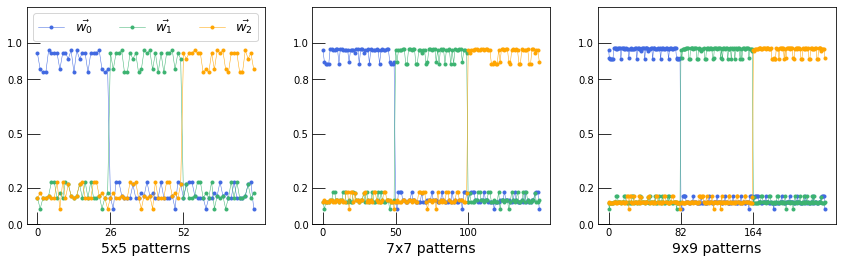

In [47]:
# demo example, for Fig 6a
ymax=1.2

fig=plt.figure(figsize=(14.5,4))
#=======
ax=fig.add_subplot(131)

line0,=ax.plot(np.arange(0,len(output_0_5x5)),output_0_5x5,marker='.',lw=0.5,color='royalblue',label='$\\vec{w_0}$')
line1,=ax.plot(np.arange(0,len(output_1_5x5)),output_1_5x5,marker='.',lw=0.5,color='mediumseagreen',label='$\\vec{w_1}$')
line2,=ax.plot(np.arange(0,len(output_2_5x5)),output_2_5x5,marker='.',lw=0.5,color='orange',label='$\\vec{w_2}$')
ax.set_ylim([0,ymax])
ax.tick_params(direction='in',size=12.5)
ax.set_yticks([0,0.2,0.5,0.8,1.0])
ax.set_xlabel('5x5 patterns',fontsize=14)
ax.legend(loc='upper left',ncol=3,fontsize=13)
ax.set_xticks([0,26,52])
#=======
ax=fig.add_subplot(132)

ax.plot(np.arange(0,len(output_0_7x7)),output_0_7x7,marker='.',lw=0.5,color='royalblue')
ax.plot(np.arange(0,len(output_1_7x7)),output_1_7x7,marker='.',lw=0.5,color='mediumseagreen')
ax.plot(np.arange(0,len(output_2_7x7)),output_2_7x7,marker='.',lw=0.5,color='orange')
ax.set_ylim([0,ymax])
ax.tick_params(direction='in',size=12.5)
ax.set_yticks([0,0.2,0.5,0.8,1.0])
ax.set_xlabel('7x7 patterns',fontsize=14)
ax.set_xticks([0,50,100])



#=======
ax=fig.add_subplot(133)

ax.plot(np.arange(0,len(output_0_9x9)),output_0_9x9,marker='.',lw=0.5,color='royalblue')
ax.plot(np.arange(0,len(output_1_9x9)),output_1_9x9,marker='.',lw=0.5,color='mediumseagreen')
ax.plot(np.arange(0,len(output_2_9x9)),output_2_9x9,marker='.',lw=0.5,color='orange')
ax.set_ylim([0,ymax])
ax.tick_params(direction='in',size=12.5)
ax.set_yticks([0,0.2,0.5,0.8,1.0])
ax.set_xlabel('9x9 patterns',fontsize=14)
ax.set_xticks([0,82,164])
